In this notebook, i am implementing logistic regression on a bi-class dataset. 
I am trying to make a classification boundary between two class.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
%matplotlib inline

The dataset has been collected from the 
<a href = 'https://www.kaggle.com/sonujha090/bank-marketing'>Bank Marketing Dataset</a>

The dataset having total rows of 45.7k with 16 features and class label as 'Y'.  

In [2]:
path = os.path.join(os.getcwd(), '..','bank-full.csv')
data = pd.read_csv(path)
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


Here, I am trying to convert the qualitative data into quantitative data. I am converting all the text values into the numbers. <br>

In above data columns, most of the columns having text values like management, married, may etc. I am giving every text label a respective number. 


In [3]:
def Convert_toNumber(data):
    data1 = data.copy()
    label_dict = {}
    for i in data1.columns:
        if (data1[i].dtype == object):
            uniques = data1[i].unique()
            count = 0
            map_dict = {}
            for j in uniques:
                map_dict[j] = count
                count += 1
            data1[i] = data1[i].map(map_dict)
            
            label_dict[i] = map_dict
    return data1, label_dict

Now, after converting the values into numbers. We have to normalize the data and seperate out the feature data with class labels. 

I am transforming, by dividing the number with maximum value of the columns.


In [4]:
def preprocess(data, class_name):
    ## Here we are normalizing the dataset.
    Y = data[class_name]
    data = data.drop(class_name, axis = 1)
    data = data / data.max()
    data = np.array(data)
    return data, Y

In [5]:
data, label_dic = Convert_toNumber(data)
proc_data, Y = preprocess(data, 'y')

Logistic Regression is a discriminative classification algorithm which uses the logit function to make predicition. 

A logit function is:

$$P(X) = \frac{1}{1 + e^{Q^T X}}$$

Logit function is also known as Sigmoid function. 


Now, we have to find the cost function for the logistic regression. 
The cost function is the function which use to estimate the natural parameters of any probability distribution. 


Cost Function for a Logistic Regression is:

$$L(Q) = -\frac{1}{N} \Sigma_{i = 1}^{N} \bigg[ c^i log_e(\frac{1}{1 + e^{Q^TX}}) + (1 - c^i) log_e\big(1 - \frac{1}{1 + e^{Q^TX}}\big) \bigg]$$


Derivative for the cost function is:

$$\frac{\partial}{\partial\theta}\big[-log_e L(\theta) \big] = \frac{1}{N}\frac{\partial}{\partial\theta} {\Sigma_{i = 0}^{N} (H(\theta) - c^i}) x^i$$

where $$H(\theta) = \frac{1}{1 + e ^{-(\theta^T x)}}$$
$c^i$ is the class label for $i^{th}$ row. <br>
$N$ is total no. of rows in the training dataset.



Using above cost function we can make modelling error of overfitting or underfitting.<br>
*Overfitting* is a type of modelling error occurs when we trying to fit model to the limited data points. Through this technique we can make our best fit for the training dataset and get highest accuracy but when will try it on testing dataset we will loose the accuracy. To avoid this type of error we are using **technique of regularization**. 

*Underfitting* is another modelling error where we are not provide the right fit for the training dataset. 

*Regularization Techniques*: Regularization technique is used to solve the problem of overfitting and underfitting over any dataset. In the regularization, we are penalizing the theta parameters by which they are not going too high or too low. We are using two regulaization technique.
    - L1 Regularization
    - L2 Regularization
    
$$L(\theta) = (cost\_function) + (regularization\_func)$$
_L1 Regularization_: It is the absolute values of the theta parameters. 

$$L1 = |\theta_1| + |\theta_2| + ... + |\theta_n|$$
$$L1 = \Sigma_{i = 0}^{N}|\theta_i|$$

_L2 Regularization_:
$$L2 = \theta_1^2 + \theta_2^2 + ... + \theta_n^2$$
$$L2 = \Sigma_{i = 0}^{N}\theta_i^2$$


In [6]:
class LogisticRegression(object):
    
    def __init__(self, alpha = 0.01, tolerance = 0.001, fit_intercept = True, theta_init = 'rand', l1_penalty = 0.001, l2_penalty = 0.001, 
                penalty = 'l2'):
        '''
        : alpha: 
              It is the learning rate default (0.01)
          tolerance:
              Minimum value to reach default (0.001)
          fit_intercept:
              Adding 0th Vetor default (True)
          theta_init:
              Initial value of theta
              rand - random values for initial vector (Default)
              zero - zero values for initial vector
              value - Giving own values
          l1_penalty:
              Value of L1 regularized penalty
          l2_penalty:
              Value of L2 regularized penalty
          penalty:
              l1: Enable l1 regularization
              l2: Enable l2 regularization
        '''
        self.alpha = alpha
        self.tolerance = tolerance 
        self.intercept = fit_intercept
        self.theta_init = theta_init
        self.penalty = penalty
        self.l2_penalty = l2_penalty
        self.l1_penalty = l1_penalty
            
    
    def __sigmoid__(self, X, weight):
        sig = 1 / (1 + np.e ** -(np.dot(X, weight)))
        return sig
    
    def __add_0th_feature__(self, X):
        
#         if X.shape[0] == self.theta.shape:
#             return (np.concatenate(([1], X)))
        ones = np.ones((X.shape[0], 1))
        return np.concatenate((ones, X), axis = 1)
    
    def predict_prob(self, X):
        if self.intercept:
            X = self.__add_0th_feature__(X)
        
        logit = self.__sigmoid__(X, self.theta).reshape((X.shape[0], 1))
        return np.concatenate((1 - logit, logit), axis = 1)
    
    def predict(self, X):
        val = self.predict_prob(X)
        return np.argmax(val, axis = 1)
        
    def __loss__(self, theta, X, Y):
        
        v = self.__sigmoid__(X, theta)
        return ((Y * np.log(v)) + ((1 - Y) * np.log(1 - v))).mean()
        
    def __gradient_descent__(self, X, Y):
        
        if self.theta_init == 'rand':
            theta_old = np.random.rand(X.shape[1])
        elif self.theta_init == 'zero':
            theta_old = np.zeros(X.shape[1])
        else:
            if len(self.theta_init) == X.shape[1]:
                theta_old = np.array(self.theta_init)
            else:
                raise(ValueError('Different dimension for the value: {} and feature: {}'.format(len(self.theta_init), X.shape[1])))
        self.loss_history = []
        self.count = 1
        
        if self.penalty == 'l1':
            func = lambda x: self.l1_penalty * np.sum(np.abs(x))
        elif self.penalty == 'l2':
            func = lambda x: self.l2_penalty * np.dot(x.T,x)
            
        
        while True:
            theta_new = theta_old - self.alpha * (np.dot((self.__sigmoid__(X, theta_old) - Y), X) / Y.shape[0]) + func(theta_old)
            loss = abs(self.__loss__(theta_new, X, Y) - self.__loss__(theta_old, X, Y))
            self.loss_history.append(loss)
            if loss < self.tolerance:
                break
            print ('Iteration: {} Loss Value: {}'.format(self.count, loss))
            theta_old = theta_new
            self.count += 1 
        
        self.theta = theta_old
        
    
    def plot_loss(self):
        plt.xlabel('# of interation -->')
        plt.ylabel('Rate of loss -->')
        plt.title('Gradient loss graph')
        plt.plot(range(self.count), self.loss_history)
            
    def fit(self, X, Y):
        
        if (self.intercept):
            X = self.__add_0th_feature__(X)
            
        
        loss = self.__gradient_descent__(X, Y)
        return loss 
#         raise(NotImplementedError('Not Imp'))

In [7]:
class Score_Matrix(object):
    
    '''
    This class has all score matrix by which we can check efficiency of our algorithm on given dataset.
    '''
    
    def __init__(self, y_actual, y_pred):
        self.y_actual = y_actual
        self.y_pred = np.array(y_pred)
        
    def confusion_matrix(self):
        self.data = pd.crosstab(self.y_actual, self.y_pred, rownames= ['actual'], colnames = ['predicted'], margins = True)
        return self.data
        
    def recall(self):
        '''
        data:
            Dataframe of confusion matrix
        '''
        sumVal = 0
        self.confusion_matrix()
        for i in self.data.columns[:-1]:
            sumVal += (self.data[i][i] / self.data['All'][i])
        return np.round(sumVal / (self.data.shape[0] - 1), 3)
    
    def check_accuracy(self):
        val = np.count_nonzero(self.y_actual == self.y_pred)
        return val / self.y_actual.shape[0]
        
    def precision(self):
        sumVal = 0
        self.confusion_matrix()
        for i in self.data.columns[:-1]:
            sumVal += (self.data[i][i] / self.data[i]['All'])
        avg = sumVal / (self.data.shape[0]- 1)
        return np.round(avg,3)
    

### Performing Logistic Regression on the **random theta vector** without **Regularization**

In [8]:
lb = LogisticRegression(l2_penalty = 0)

In [9]:
lb.fit(proc_data[:100], Y[:100])

Iteration: 1 Loss Value: 0.01188790229619352
Iteration: 2 Loss Value: 0.011850812393245924
Iteration: 3 Loss Value: 0.01181344782969651
Iteration: 4 Loss Value: 0.011775809747060606
Iteration: 5 Loss Value: 0.011737899362600501
Iteration: 6 Loss Value: 0.01169971796983127
Iteration: 7 Loss Value: 0.011661266938979509
Iteration: 8 Loss Value: 0.011622547717395904
Iteration: 9 Loss Value: 0.011583561829934919
Iteration: 10 Loss Value: 0.011544310879289643
Iteration: 11 Loss Value: 0.01150479654626535
Iteration: 12 Loss Value: 0.011465020590039288
Iteration: 13 Loss Value: 0.01142498484834853
Iteration: 14 Loss Value: 0.011384691237626754
Iteration: 15 Loss Value: 0.011344141753124815
Iteration: 16 Loss Value: 0.011303338468944935
Iteration: 17 Loss Value: 0.011262283538048035
Iteration: 18 Loss Value: 0.011220979192199998
Iteration: 19 Loss Value: 0.011179427741875969
Iteration: 20 Loss Value: 0.011137631576095153
Iteration: 21 Loss Value: 0.0110955931622303
Iteration: 22 Loss Value: 0.0

Iteration: 306 Loss Value: 0.0015206236862909117
Iteration: 307 Loss Value: 0.0015097403623009487
Iteration: 308 Loss Value: 0.0014989522830930468
Iteration: 309 Loss Value: 0.0014882585495865075
Iteration: 310 Loss Value: 0.0014776582703762697
Iteration: 311 Loss Value: 0.0014671505617085967
Iteration: 312 Loss Value: 0.0014567345474539861
Iteration: 313 Loss Value: 0.0014464093590779714
Iteration: 314 Loss Value: 0.0014361741356169189
Iteration: 315 Loss Value: 0.0014260280236444989
Iteration: 316 Loss Value: 0.0014159701772396005
Iteration: 317 Loss Value: 0.0014059997579600747
Iteration: 318 Loss Value: 0.0013961159348019891
Iteration: 319 Loss Value: 0.0013863178841696522
Iteration: 320 Loss Value: 0.0013766047898411404
Iteration: 321 Loss Value: 0.0013669758429283863
Iteration: 322 Loss Value: 0.001357430241843871
Iteration: 323 Loss Value: 0.0013479671922596026
Iteration: 324 Loss Value: 0.0013385859070719208
Iteration: 325 Loss Value: 0.0013292856063572
Iteration: 326 Loss Valu

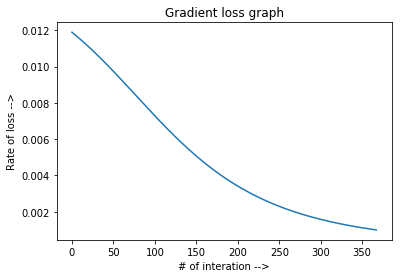

In [10]:
lb.plot_loss()

In [11]:
pred = lb.predict(proc_data[100:])

In [12]:
sm = Score_Matrix(Y[100:], pred)
print ('Accuracy on testing dataset: %.3f'%sm.check_accuracy())

Accuracy on testing dataset: 0.848


In [13]:
sm.confusion_matrix()

predicted,0,1,All
actual,,,
0,36856,2969,39825
1,3877,1409,5286
All,40733,4378,45111


### Performing Logistic Regression on the zero theta vector with **L2 regularization.**

In [14]:
lb = LogisticRegression(theta_init = 'zero')

In [15]:
lb.fit(proc_data[:100], Y[:100])

Iteration: 1 Loss Value: 0.0035640551544977583
Iteration: 2 Loss Value: 0.003534943648440647
Iteration: 3 Loss Value: 0.003505972529070034
Iteration: 4 Loss Value: 0.00347714395185994
Iteration: 5 Loss Value: 0.0034484599907197433
Iteration: 6 Loss Value: 0.0034199226389259874
Iteration: 7 Loss Value: 0.0033915338100689585
Iteration: 8 Loss Value: 0.0033632953390352327
Iteration: 9 Loss Value: 0.0033352089830126497
Iteration: 10 Loss Value: 0.0033072764225102746
Iteration: 11 Loss Value: 0.0032794992624144426
Iteration: 12 Loss Value: 0.003251879033048466
Iteration: 13 Loss Value: 0.0032244171912653163
Iteration: 14 Loss Value: 0.0031971151215437477
Iteration: 15 Loss Value: 0.003169974137109288
Iteration: 16 Loss Value: 0.0031429954810673344
Iteration: 17 Loss Value: 0.0031161803275426836
Iteration: 18 Loss Value: 0.0030895297828416046
Iteration: 19 Loss Value: 0.003063044886607469
Iteration: 20 Loss Value: 0.003036726613004581
Iteration: 21 Loss Value: 0.0030105758718923514
Iteration

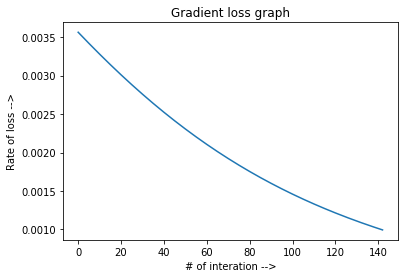

In [16]:
lb.plot_loss()

In [17]:
pred = lb.predict(proc_data[100:])

In [18]:
sm = Score_Matrix(Y[100:], pred)

In [19]:
print ('Accuracy on testing dataset: %.3f'%sm.check_accuracy())

Accuracy on testing dataset: 0.883


In [20]:
sm.confusion_matrix()

predicted,0,All
actual,,
0,39825,39825
1,5286,5286
All,45111,45111


### Performing Logistic Regression on zero theta vector and **L1 Regularization**. 

In [21]:
lb = LogisticRegression(theta_init = 'zero', penalty='l1', l1_penalty=0.00001)

In [22]:
lb.fit(proc_data[:100], Y[:100])

Iteration: 1 Loss Value: 0.0035640551544977583
Iteration: 2 Loss Value: 0.003534796083763614
Iteration: 3 Loss Value: 0.0035057793818951133
Iteration: 4 Loss Value: 0.0034770038903444433
Iteration: 5 Loss Value: 0.0034484684281612665
Iteration: 6 Loss Value: 0.0034201717929066566
Iteration: 7 Loss Value: 0.0033921127615286206
Iteration: 8 Loss Value: 0.003364290091249167
Iteration: 9 Loss Value: 0.0033367025204165124
Iteration: 10 Loss Value: 0.0033093487693496293
Iteration: 11 Loss Value: 0.003282227541173799
Iteration: 12 Loss Value: 0.0032553375226315184
Iteration: 13 Loss Value: 0.003228677384882306
Iteration: 14 Loss Value: 0.003202245784291513
Iteration: 15 Loss Value: 0.0031760413631966022
Iteration: 16 Loss Value: 0.00315006275066243
Iteration: 17 Loss Value: 0.0031243085632232104
Iteration: 18 Loss Value: 0.003098777405601938
Iteration: 19 Loss Value: 0.0030734678714248176
Iteration: 20 Loss Value: 0.0030483785439111566
Iteration: 21 Loss Value: 0.0030235079965545975
Iteration

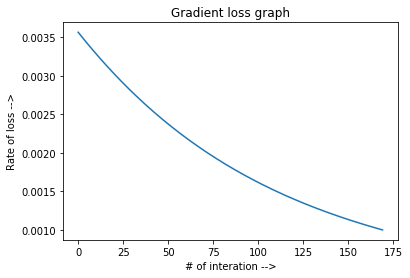

In [23]:
lb.plot_loss()

In [24]:
pred = lb.predict(proc_data[100:])

In [25]:
sm = Score_Matrix(Y[100:], pred)

In [26]:
print ('Accuracy on testing dataset: %.3f'%sm.check_accuracy())

Accuracy on testing dataset: 0.883


In [27]:
sm.confusion_matrix()

predicted,0,All
actual,,
0,39825,39825
1,5286,5286
All,45111,45111


### Implementing Logistic Regression using Scikit-Learn and checking for the accuracy

In [28]:
from sklearn.linear_model import LogisticRegression

In [29]:
l_sklearn = LogisticRegression(verbose = 1)

In [30]:
l_sklearn.fit(proc_data[:100], Y[:100])

[LibLinear]

C:\Users\ritik\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=1, warm_start=False)

In [31]:
pred_sklearn = l_sklearn.predict(proc_data[100:])

In [32]:
sklearn_sm = Score_Matrix(Y[100:], pred_sklearn)

In [33]:
print ('Accuracy on testing dataset: %.3f'%sklearn_sm.check_accuracy())

Accuracy on testing dataset: 0.883


In [34]:
sklearn_sm.confusion_matrix()

predicted,0,All
actual,,
0,39825,39825
1,5286,5286
All,45111,45111
